# Post-wildfire Vegetation Recovery
## In this Jupyter notebook, we find the reflectance spectra for all of the subplots of plot 55. 
### For each subplot: 
* we find the pixel coordinates that correspond to the UTM coordinates of the subplot,
* we clean the data for water absorption and noisy data,
* and we plot the reflectance spectrum.

Author: Heidi Yoon

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import h5py
import earthpy as et

# Ignore any warnings
warnings.filterwarnings('ignore')

# Check module path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
import modules.reflectance as refl

In [2]:
# Get NEON reflectance data from NEON API
# Endpoints are data product, site, date, and release year
neon_base = "https://data.neonscience.org/api/v0/data"
data_product = "/DP3.30006.001"
site = "/GRSM"
post_fire_release = "/2017-10?package=basic&release=RELEASE-2022"
post_fire_url = neon_base + data_product + site + post_fire_release
post_fire_data = requests.get(post_fire_url)

# Similarly for the pre-fire data
pre_fire_release = "/2016-06?package=basic&release=RELEASE-2022"
pre_fire_url = neon_base + data_product + site + pre_fire_release
pre_fire_data = requests.get(pre_fire_url)

In [3]:
# Using API response, find the url corresponding to tile of interest
post_fire_df = pd.json_normalize(post_fire_data.json()['data']['files'])
pre_fire_df = pd.json_normalize(pre_fire_data.json()['data']['files'])

In [4]:
# Define data directory and data paths
data_dir = os.path.join(project_path, 'data')
post_data_path = os.path.join(
    data_dir, 'NEON_GRSM_273000_3951000_201710_reflectance.h5')
pre_data_path = os.path.join(
    data_dir, 'NEON_GRSM_273000_3951000_201606_reflectance.h5')

# Check if data directory exists
try:
    os.makedirs(data_dir)
    print('The data directory has been created!')
except FileExistsError:
    print('The data directory already exists!')

The data directory already exists!


In [5]:
# Need tile 273000_3951000 for plot 55
# Get NEON reflectance data
postfire_h5 = 'NEON_D07_GRSM_DP3_273000_3951000_reflectance.h5'
prefire_h5 = 'NEON_D07_GRSM_DP3_273000_3951000_reflectance.h5'

post_fire_url = post_fire_df[post_fire_df['name'] == postfire_h5]['url'].iloc[0]
pre_fire_url = pre_fire_df[pre_fire_df['name'] == prefire_h5]['url'].iloc[0]

post_data = refl.download_file(post_data_path, post_fire_url)
pre_data = refl.download_file(pre_data_path, pre_fire_url)

In [6]:
# Open NEON data and store reflectance array and metadata
post_fire_refl, post_fire_metadata = refl.aop_h5refl2array(post_data_path)
pre_fire_refl, pre_fire_metadata = refl.aop_h5refl2array(pre_data_path)

### We would like to find pixel_x and pixel_y that correspond to the UTM coordinates. UTM easting corresponds to x, and UTM northing corresponds to y. In pixel space, the origin (0, 0) is located in the upper left corner of the raster. In UTM coordinates, the origin of the tile of interest (273000, 3951000) is located in the lower left corner of the raster. By these definitions, the following relations follow:
* pixel_x = (east_coordinate) - (east_origin)
* pixel_y = (north_origin) - (north_coordinate)

### Given the UTM coordinates of all of the subplots of Plot 55 (see `vegetation_subplots.ipynb`), we can plot each reflectance spectrum for a given (pixel_x, pixel_y) for all wavelengths.

In [7]:
# Open dataframe with all the UTM coordinates for the subplots
grsm_plots_path = os.path.join(
    project_path, 'outputs', 'grsm_plots_coords.csv')
plots_df = pd.read_csv(grsm_plots_path)
plots_df[plots_df['name']=='GRSM_055.basePlot.div.40.1.1']

,name,utm-easting,utm-northing
48,GRSM_055.basePlot.div.40.1.1,273554.33395,3.951956e+06


### As an example, let's consider subplot 40.1.1 located at (273554, 3951956). Using the UTM coordinates, we can calculate the corresponding (pixel_x, pixel_y) as (554, 44). Note that the tile coordinates are (y, x, wavelength).

In [9]:
grsm_4011_df = pd.DataFrame()
grsm_4011_df['reflectance'] = post_fire_refl[44,554,:]
grsm_4011_df['wavelength'] = post_fire_metadata['wavelength']

### We can plot the reflectance spectrum for subplot 40.1.1 below. Note that red dotted lines denote regions where we need to correct for water absorption. We will clean the data in these regions and the last 10 points, which are typically noisy, with NaN values below.

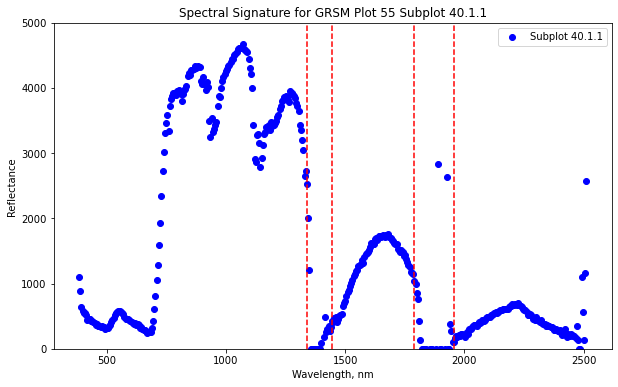

In [10]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(grsm_4011_df.wavelength,
           grsm_4011_df.reflectance,
           color='blue',
           label='Subplot 40.1.1')

# Set plot title and axes labels
ax.set(title = "Spectral Signature for GRSM Plot 55 Subplot 40.1.1",
       xlabel = "Wavelength, nm",
       ylabel = "Reflectance")
ax.set(ylim=[0, 5000])

ax.legend(loc='upper right')

#Add in red dotted lines to show boundaries of bad band windows:
ax.plot((1340,1340),(0,15000), 'r--')
ax.plot((1445,1445),(0,15000), 'r--')
ax.plot((1790,1790),(0,15000), 'r--')
ax.plot((1955,1955),(0,15000), 'r--')

plt.show()

In [11]:
# Clean reflectance spectrum
refl.clean_refl_spectrum(grsm_4011_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

### We can plot the spectrum for subplot 40.1.1 again to confirm that we have cleaned the data.

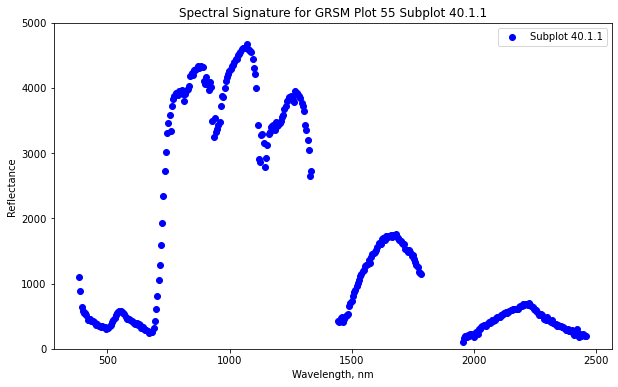

In [12]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(grsm_4011_df.wavelength,
           grsm_4011_df.reflectance,
           color='blue',
           label='Subplot 40.1.1')

# Set plot title and axes labels
ax.set(title = "Spectral Signature for GRSM Plot 55 Subplot 40.1.1",
       xlabel = "Wavelength, nm",
       ylabel = "Reflectance")
ax.set(ylim=[0, 5000])

ax.legend(loc='upper right')

plt.show()

### We can do the similar analysis for the other subplots in Plot 55.

In [13]:
grsm_4031_df = pd.DataFrame()
grsm_4031_df['reflectance'] = post_fire_refl[35,554,:]
grsm_4031_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_4031_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [14]:
grsm_4111_df = pd.DataFrame()
grsm_4111_df['reflectance'] = post_fire_refl[45,565,:]
grsm_4111_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_4111_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [15]:
grsm_4141_df = pd.DataFrame()
grsm_4141_df['reflectance'] = post_fire_refl[36,573,:]
grsm_4141_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_4141_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [16]:
grsm_3111_df = pd.DataFrame()
grsm_3111_df['reflectance'] = post_fire_refl[55,553,:]
grsm_3111_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_3111_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [17]:
grsm_3141_df = pd.DataFrame()
grsm_3141_df['reflectance'] = post_fire_refl[46,564,:]
grsm_3141_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_3141_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [18]:
grsm_3221_df = pd.DataFrame()
grsm_3221_df['reflectance'] = post_fire_refl[55,572,:]
grsm_3221_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_3221_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

In [19]:
grsm_3241_df = pd.DataFrame()
grsm_3241_df['reflectance'] = post_fire_refl[46,572,:]
grsm_3241_df['wavelength'] = post_fire_metadata['wavelength']
refl.clean_refl_spectrum(grsm_3241_df['wavelength'])

0      383.534302
1      388.542206
2      393.550110
3      398.558014
4      403.565887
          ...    
421           NaN
422           NaN
423           NaN
424           NaN
425           NaN
Name: wavelength, Length: 426, dtype: float32

### We can summarize our results by plotting the left-most subplots, then the right-most subplots, and lastly the middle subplots.

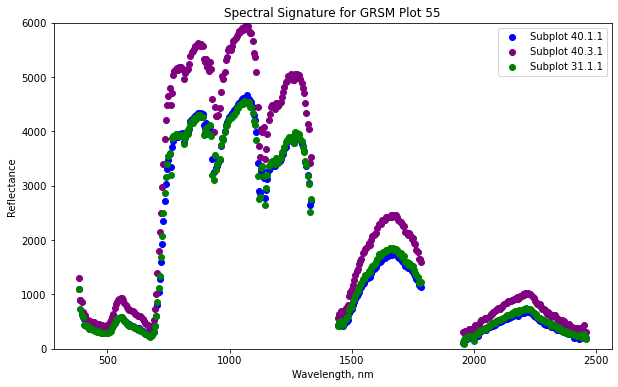

In [25]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(grsm_4011_df.wavelength,
           grsm_4011_df.reflectance,
           color='blue',
           label='Subplot 40.1.1')
ax.scatter(grsm_4031_df.wavelength,
           grsm_4031_df.reflectance,
           color='purple',
           label='Subplot 40.3.1')
ax.scatter(grsm_3111_df.wavelength,
           grsm_3111_df.reflectance,
           color='green',
           label='Subplot 31.1.1')

# Set plot title and axes labels
ax.set(title = "Spectral Signature for GRSM Plot 55",
       xlabel = "Wavelength, nm",
       ylabel = "Reflectance")
ax.set(ylim=[0, 6000])

ax.legend(loc='upper right')

plt.show()

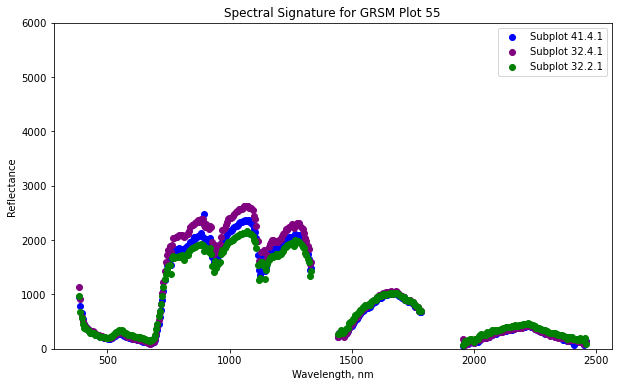

In [26]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(grsm_4141_df.wavelength,
           grsm_4141_df.reflectance,
           color='blue',
           label='Subplot 41.4.1')
ax.scatter(grsm_3241_df.wavelength,
           grsm_3241_df.reflectance,
           color='purple',
           label='Subplot 32.4.1')
ax.scatter(grsm_3221_df.wavelength,
           grsm_3221_df.reflectance,
           color='green',
           label='Subplot 32.2.1')

# Set plot title and axes labels
ax.set(title = "Spectral Signature for GRSM Plot 55",
       xlabel = "Wavelength, nm",
       ylabel = "Reflectance")
ax.set(ylim=[0, 6000])

ax.legend(loc='upper right')

plt.show()

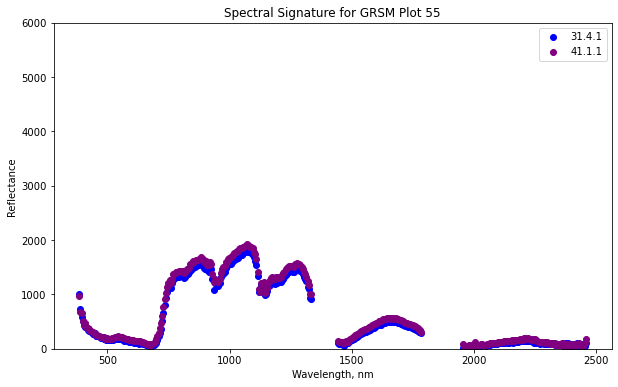

In [27]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Define x and y axes
ax.scatter(grsm_3141_df.wavelength,
           grsm_3141_df.reflectance,
           color='blue',
           label='31.4.1')
ax.scatter(grsm_4111_df.wavelength,
           grsm_4111_df.reflectance,
           color='purple',
           label='41.1.1')

# Set plot title and axes labels
ax.set(title = "Spectral Signature for GRSM Plot 55",
       xlabel = "Wavelength, nm",
       ylabel = "Reflectance")
ax.set(ylim=[0, 6000])

ax.legend(loc='upper right')

plt.show()